# Foundation of Deep Learning
Group Challenge

***
by: Oskar Girardin (B00792974), Lasse Schmidt (B00792989)

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

### 1. Import Packages

In [2]:
from importlib import reload
reload(prepData)
reload(loadData)
reload(vizData)
reload(model_functions)

NameError: name 'loadData' is not defined

In [3]:
# import own scripts
import util.preprocess_data as prepData
import util.load_data as loadData
import util.visualize_data as vizData
import util.model_training_evaluation_prediction as model_functions

In [4]:
# parse & handle data
import configparser
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np
from PIL import Image, ImageOps
import tarfile

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# hyperparam optimization
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial

# pretrained models
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as smp_utils

# evaluation metrics
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# visualization
import matplotlib.pyplot as plt

In [5]:
# set matplotlib and seaborn settings for nicer plots

%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Fetch Core Settings from .ini file

In [6]:
# fetch .ini
config = configparser.ConfigParser()
config.read("util/config.ini")
config_w = config["write_paths"]

# paths where we want to save sliced training data (test data will not be sliced!)
X_train_prep_path, y_train_prep_path = config_w["X_train_prep_path"], config_w["y_train_prep_path"]
X_val_prep_path, y_val_prep_path = config_w["X_val_prep_path"], config_w["y_val_prep_path"]
X_test_prep_path = config_w["X_test_prep_path"]

# path where we want to save predictions
save_preds_val = config_w["save_preds_val"]
save_preds_test = config_w["save_preds_test"]

# path where RayTune results should be saved
ray_path = config_w["ray_path"]

# directory of this notebook
notebook_path = loadData.get_notebook_path()

### 3. Retrieve Data

In [7]:
# get class dict
class_dict = loadData.get_class_dict()

# show number of classes
print(f"Number of classes: {len(class_dict)}")

Number of classes: 27


In [8]:
# get paths to training, validation and test data
X_train_paths, y_train_paths, X_val_paths, y_val_paths, X_test_paths = loadData.get_train_val_test_doc_paths()

In [9]:
# preprocess training data (slicing)
X_train_prep_paths = prepData.slice_images(X_train_paths, X_train_prep_path, verbose = True)
y_train_prep_paths = prepData.slice_images(y_train_paths, y_train_prep_path, verbose = True)

In [10]:
# preprocess validation & test data (with this setup, we MUST use batch_size = 1 for these datasets)
X_val_prep_paths  = prepData.compress_image_size(X_val_paths, X_val_prep_path, verbose = True)
y_val_prep_paths  = prepData.compress_image_size(y_val_paths, y_val_prep_path, verbose = True)
X_test_prep_paths = prepData.compress_image_size(X_test_paths, X_test_prep_path, verbose = True)

In [11]:
trainset, valset, testset = loadData.get_datasets()
# show sizes of datasets
print(f"Size of training data: {trainset.__len__()}")
print(f"Size of validation data: {valset.__len__()}")
print(f"Size of test data: {testset.__len__()}")

Size of training data: 1614
Size of validation data: 30
Size of test data: 75


### 4. Validate Data (and their preprocessing!)

In [12]:
# validate that masks have been parsed correctly (training)
# a should be subset (slice) of b
key = list(trainset.mask_paths.keys())[4]

a = np.asarray(Image.open(trainset.mask_paths[key])) 
print(np.unique(a, return_index = True))

b = np.asarray(Image.open(y_train_paths[key[:-2]]))
print(np.unique(b, return_index = True))

(array([ 0,  1,  4,  5,  6,  8, 10, 24, 26], dtype=uint8), array([    0,   529,  5180,   333,  8658,  3242, 42950,  7494,  2138]))
(array([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 16, 24, 26], dtype=uint8), array([     0,  11721,   7336, 331164, 101929,  13616,  10949, 142313,
        95424,  13165,   8002,  93895]))


In [13]:
# validate that masks have been parsed correctly (validation)
# a should be exactly b (but in lower resolution, so counts are proportionately lower)
key = list(valset.mask_paths.keys())[2]

a = np.asarray(Image.open(valset.mask_paths[key]))
print(np.unique(a, return_index = True))

b = np.asarray(Image.open(y_val_paths[key]))
print(np.unique(b, return_index = True))

(array([ 0,  1,  3,  4,  5,  6,  8,  9, 10, 14, 16, 26], dtype=uint8), array([     0,    567,    213, 261665,    345,     74, 148012, 583946,
       852344,    747,     15, 245730]))
(array([ 0,  1,  3,  4,  5,  6,  8,  9, 10, 14, 16, 26], dtype=uint8), array([       0,     2137,      770,  3152559,     1425,      256,
        1773937,  7027594, 10263531,     2593,       60,  2961234]))


(333, 375)
(288, 320)


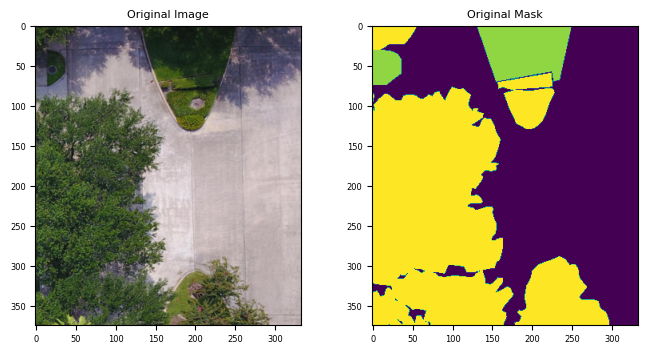

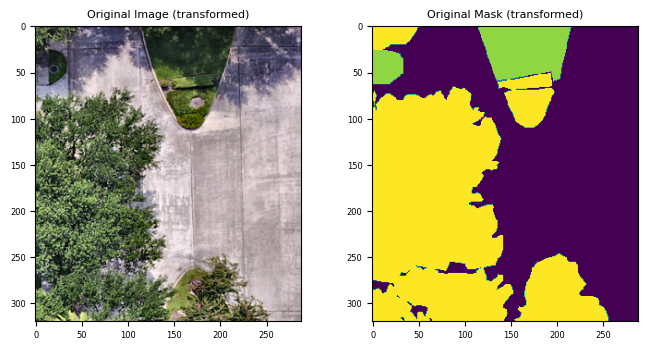

In [14]:
# fetch random image & mask for visualization (training)
idx = 4
key = list(X_train_prep_paths.keys())[idx]

# print raw output (without transformations)
raw_img = Image.open(X_train_prep_paths[key])
raw_mask = Image.open(y_train_prep_paths[key])
vizData.visualize(raw_img, raw_mask)

# print transformed output
transform_train_viz, transform_valtest_viz = prepData.get_transforms(config, visualize = True)
vizData.visualize(raw_img, raw_mask, transform = transform_train_viz)

(1152, 864)
(1152, 864)


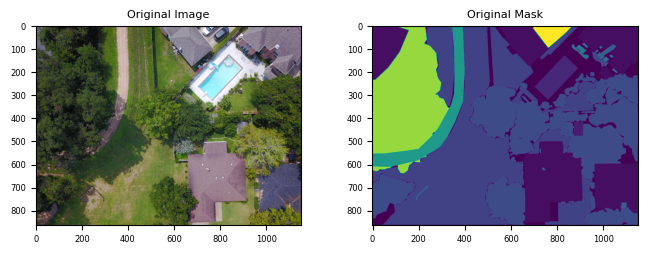

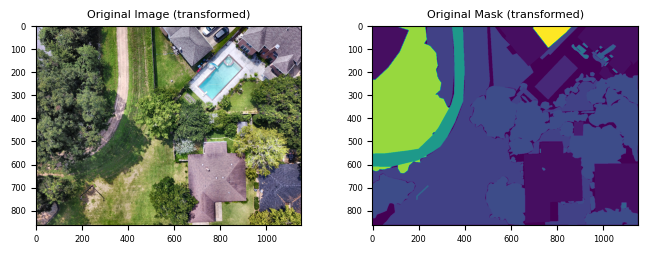

In [13]:
# fetch random image & mask for visualization (validation)
idx = 11
key = list(X_val_prep_paths.keys())[idx]

# print raw output (without transformations)
raw_img = Image.open(X_val_prep_paths[key])
raw_mask = Image.open(y_val_prep_paths[key])
vizData.visualize(raw_img, raw_mask)

# print transformed output
transform_train_viz, transform_valtest_viz = prepData.get_transforms(config, visualize = True)
vizData.visualize(raw_img, raw_mask, transform = transform_valtest_viz)

### 5. Train Models

In [20]:
# train the model ("efficientnet-b2" only for batch size 2, efficientnet-b3 always out of memory)
param_space = {
    # variable passing
    "max_epochs": tune.choice([32]),
    
    # tunable hyperparams
    "model": tune.choice(["DeepLabV3", "DeepLabV3Plus"]), # "DeepLabV3", "DeepLabV3Plus", "UNet", "Linknet", "FPN", "PSPNET"
    "encoder": tune.choice(["resnet18"]), # "resnet18", "vgg13", "resnext50_32x4d",
    "batch_size": tune.choice([16]),
    "lr": tune.uniform(1e-5, 1e-3), # 1e-5, 1e-3 for Cosine, OneCycle // ?? for Cyclic
    "lr_scheduler": tune.choice(["OneCycle"]) # "Cosine", "Cyclic" (Cyclic never worked well so far!)
}

In [15]:
#scheduler = ASHAScheduler(
#    time_attr = "training_iteration",
#    max_t = int(search_space["max_epochs"]),
#    grace_period = 10,
#    reduction_factor = 2)

# this didn't work at all! ran infinitely after having terminated half of the runs
#scheduler = MedianStoppingRule(
#    time_attr = "training_iteration",
#    grace_period = 10,
#    min_samples_required = 5
#)

# central issue: in PBT we want to change hyperparams during training (within the epoch loop)
# right now, only learning rate could possibly be adapted like this (but would directly be
# overwritten by learning rate scheduler)
#scheduler = PopulationBasedTraining(
#    time_attr = "training_iteration",
#    metric = "loss",
#    mode = "min",
#    perturbation_interval = 4,
#    burn_in_period = 4,
#    hyperparam_mutations = param_space
#    )

In [19]:
def trial_str_creator(trial):
    model = trial.evaluated_params["model"]
    encoder = trial.evaluated_params["encoder"]
    lr_scheduler = trial.evaluated_params["lr_scheduler"]
    return f"{model}_{encoder}_{lr_scheduler}_{trial.trial_id}"

reporter = JupyterNotebookReporter(
    metric_columns=["loss", "max_val_acc", "training_iteration"],
    parameter_columns=["model", "encoder", "batch_size", "lr", "lr_scheduler"],
    max_column_length = 10,
    max_progress_rows = 30,
    max_report_frequency = 10, # refresh output table every 10 seconds 
    print_intermediate_tables = True
)

scheduler = MedianStoppingRule(
    time_attr = "training_iteration",
    grace_period = 10,
    min_samples_required = 3
)

search_alg = HyperOptSearch()

# stopper = MaximumIterationStopper(max_iter = int(search_space["max_epochs"]))

tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(model_functions.train_model),
        resources={"cpu": 4, "gpu": 1}
    ),
    tune_config = tune.TuneConfig(
        metric = "loss",
        mode = "min",
        search_alg = search_alg,
        scheduler = scheduler,
        num_samples = 20,
        max_concurrent_trials = 1, # sequential optimization (one run after another) due to GPU memory constraint
        trial_name_creator = trial_str_creator,
        trial_dirname_creator = trial_str_creator,
        ),
    run_config = air.RunConfig(
        #name = exp_name,
        #stop = stopper, ## REMOVE THIS IF NECESSARY
        local_dir = ray_path,
        progress_reporter = reporter,
        verbose = 1),
    param_space = param_space
)

result_grid = tuner.fit()

2023-01-15 16:41:57,032	INFO tune.py:887 -- Initializing Ray automatically.For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run`.
2023-01-15 16:41:58,250	ERROR services.py:1195 -- Failed to start the dashboard: Failed to start the dashboard, return code 1
Failed to read dashboard log: [Errno 2] No such file or directory: '/tmp/ray/session_2023-01-15_16-41-57_044304_939/logs/dashboard.log'
2023-01-15 16:41:58,252	ERROR services.py:1196 -- Failed to start the dashboard, return code 1
Failed to read dashboard log: [Errno 2] No such file or directory: '/tmp/ray/session_2023-01-15_16-41-57_044304_939/logs/dashboard.log'
Traceback (most recent call last):
  File "/opt/anaconda3/envs/torch/lib/python3.9/site-packages/ray/_private/services.py", line 1167, in start_api_server
    with open(dashboard_log, "rb") as f:
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/ray/session_2023-01-15_16-41-57_044304_939/logs/dashboard.log'

During handling of the

TuneError: The Ray Tune run failed. Please inspect the previous error messages for a cause. After fixing the issue, you can restart the run from scratch or continue this run. To continue this run, you can use `tuner = Tuner.restore("/Users/oskar/Documents/DSBA/M2/FDL/Group_project/ray_results/train_model_2023-01-15_16-41-57")`.

#### Other ideas

1. tune.search.bohb.TuneBOHB -> BOHB (Bayesian Optimization HyperBand) is an algorithm that both terminates bad trials and also uses Bayesian Optimization to improve the hyperparameter search. BOHB is intended to be paired with a specific scheduler class: HyperBandForBOHB.
2. Rerun ASHAScheduler with concurrent = 1
3. Do not re-train all model weights (see here https://liebertpub.com/doi/full/10.1089/big.2021.0218, https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) but only first conv and last fully connected layers!

### 6. Evaluate a given RayTune Experiment

In [14]:
experiment_path = ray_path + "train_model_2023-01-14_23-39-31\\"

print(f"Loading results from {experiment_path}...")
restored_tuner = tune.Tuner.restore(experiment_path)
result_grid = restored_tuner.get_results()
print("Done!")

Loading results from D:\Dokumente\2_Bildung\2_MSc\1_Classes\Foundations of Deep Learning\5_group project\ray_results\train_model_2023-01-14_23-39-31\...
Done!


In [15]:
# Check if there have been errors
if result_grid.errors:
    print(f"At least one of the {len(result_grid)} trials failed!")
else:
    print(f"No errors! Number of terminated trials: {len(result_grid)}")

No errors! Number of terminated trials: 20


In [18]:
# get best score per trial (highest validation accuracy)
N = 3
best_result_df = result_grid.get_dataframe(
    filter_metric="val_acc", filter_mode="max"
)
best_result_df = best_result_df[["config/model", "config/encoder", "config/lr", "config/lr_scheduler",
                                 "trial_id", "training_iteration", "loss", "val_acc"]]
best_result_df = best_result_df.sort_values(by=["val_acc"], ascending = False)

if len(result_grid) > N:
    best_result_df = best_result_df.head(N)

best_result_df

,config/model,config/encoder,config/lr,config/lr_scheduler,trial_id,training_iteration,loss,val_acc
19,DeepLabV3,resnet18,0.00005,OneCycle,f9850741,25,2.573478,0.784363
13,DeepLabV3Plus,resnet18,0.00010,Cosine,c9140011,21,2.584975,0.781849
6,DeepLabV3Plus,resnet18,0.00010,Cosine,481748a9,19,2.588306,0.777012


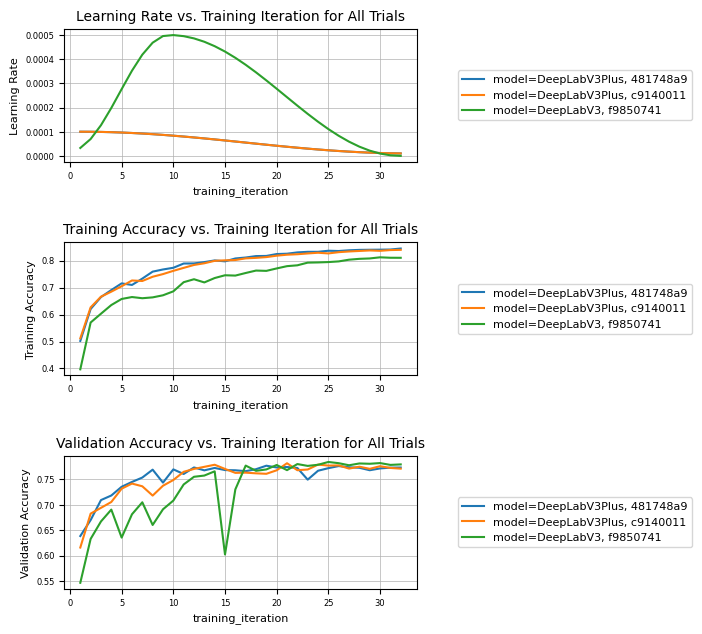

In [27]:
# learning rate vs training epochs

plot_metrics = {"Learning Rate": "cur_lr",
                "Training Accuracy": "trn_acc",
                "Validation Accuracy": "val_acc",
                "Bias": "bias"}

fig, axs = plt.subplots(len(plot_metrics), 1, figsize = (4, 6))
fig.tight_layout(h_pad = 7)

thresh = 0
if len(result_grid) > N:
    thresh = min(best_result_df["val_acc"])

for ax, (key, value) in zip(axs, plot_metrics.items()):
    for result in result_grid:
        if result.metrics["max_val_acc"] >= thresh: # only plot result if max_val_acc above required thresh
            label = f"model={result.config['model']}, {result.metrics['trial_id']}"
            result.metrics_dataframe.plot("training_iteration", value, ax=ax, label=label)

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', markerscale = 1, bbox_to_anchor = (1.1, 0.5))
    # add a grid for better reading
    ax.grid(linewidth = 0.5)
    # set titles
    ax.set_title(f"{key} vs. Training Iteration for All Trials")
    ax.set_ylabel(f"{key}")

### 7. Predictions of best model on validation data

In [55]:
# try out \ray_results\train_model_2023-01-13_23-57-55\cd6892f4

In [14]:
## load best model
path = os.path.abspath("")+"\\Models\\best-model.pt"
best_model = smp.DeepLabV3(encoder_name = "resnet18", classes = len(class_dict), activation = "softmax2d")

best_model.load_state_dict(torch.load(path))
best_model = best_model

In [15]:
# if this gives a Pickle Error, just restart the kernel!
# (might happen if you use the reload package in very first cell of this notebook)
y_val_pred_paths = model_functions.predict(best_model, valset, save_preds_val, test = False)

(1152, 864)
(1152, 864)
85.8% of all pixels correctly identified!


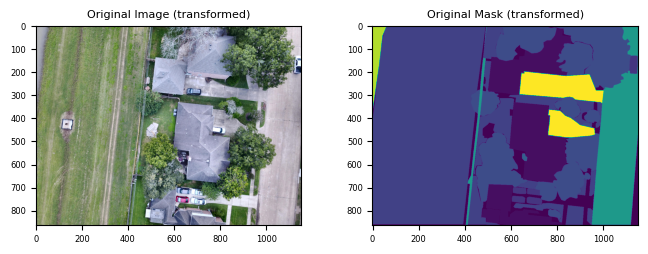

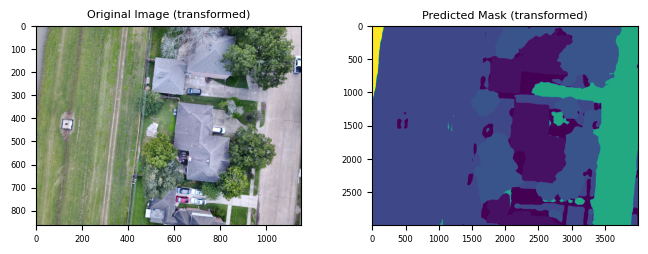

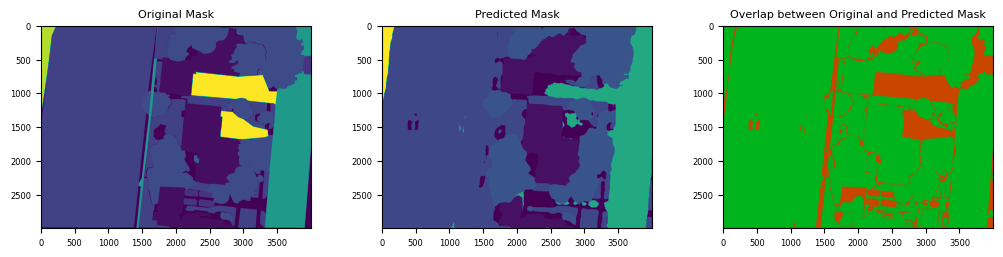

In [16]:
# fetch random validation image & its original mask and its predicted mask for visualization
idx = 1
key = list(X_val_prep_paths.keys())[idx]

# compare
# (1) preprocessed & transformed image and mask
# (2) preprocessed & transformed image and predicted mask
prep_img = Image.open(X_val_prep_paths[key])
prep_mask = Image.open(y_val_prep_paths[key])
pred_mask = Image.open(y_val_pred_paths[key])
vizData.visualize(prep_img, prep_mask, transform_valtest_viz)
vizData.visualize(prep_img, pred_mask, transform_valtest_viz, pred = True)

# evaluate original vs predicted mask
org_mask = Image.open(y_val_paths[key])
vizData.evaluate_pred(org_mask, pred_mask)

### 8. Predictions of best model on test data

In [17]:
## predict on test data
y_test_paths = model_functions.predict(best_model, testset, save_preds_test)

(4592, 3072)
(1152, 768)


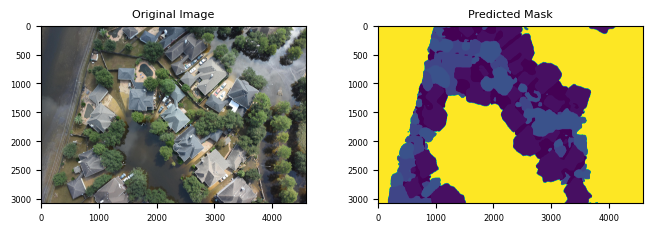

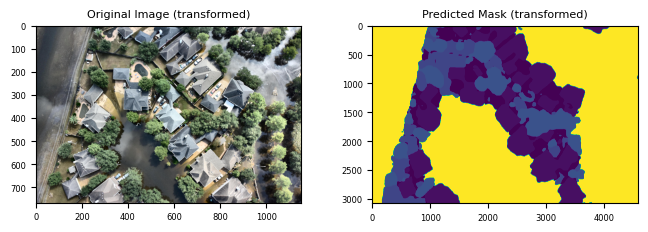

In [18]:
# fetch random test image & prediction mask for visualization
idx = 30
key = list(X_test_paths.keys())[idx]

# print raw output (without transformations)
org_img = Image.open(X_test_paths[key])
prep_img = Image.open(X_test_prep_paths[key])
pred_mask = Image.open(y_test_paths[key])
vizData.visualize(org_img, pred_mask, pred = True)
vizData.visualize(prep_img, pred_mask, transform_valtest_viz, pred = True)

In [19]:
# create submission file
tar = tarfile.open("submission.tar", "w")
for (root, dirs, files) in os.walk(save_preds_test):
    for file in files:
        fullpath = os.path.join(root, file)
        tar.add(fullpath, arcname=file)
tar.close()

### X. Code Graveyard
too sad to delete, maybe keep for later

In [45]:
## KEEP FOR DEBUGGING TRAINABLE FUNCTION

param_space = {
    # variable passing
    "max_epochs": 32,
    
    # tunable hyperparams
    "model": "UNet", # "UNet", "Linknet", "FPN", "PSPNET"
    "encoder": "resnet18", # "resnet18", "vgg13", "resnext50_32x4d",
    "batch_size": 32,
    "lr": 5e-5, # 5e-5 too low for cosine (?)
    "lr_scheduler": "Cosine"
}

train_model(param_space)

KeyboardInterrupt: 

In [44]:
def get_accuracy(outputs, mask):
    outputs = torch.argmax(outputs, dim=1)
    correct = torch.eq(outputs, mask).int()
    return float(correct.sum()) / float(correct.numel())

def get_dataloader(dataset, batch_size, num_workers = 4):
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers)
    return dataloader

def train_model(config):
    # model initialisation
    class_dict = loadData.get_class_dict()
    if config["model"] == "UNet":
        model = smp.Unet(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")
    elif config["model"] == "Linknet":
        model = smp.Linknet(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")
    elif config["model"] == "FPN":
        model = smp.FPN(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")
    elif config["model"] == "PSPNET":
        model = smp.PSPNet(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")
    elif config["model"] == "DeepLabV3":
        model = smp.DeepLabV3(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")
    elif config["model"] == "DeepLabV3Plus":
        model = smp.DeepLabV3Plus(encoder_name = config["encoder"], classes = len(class_dict), activation = "softmax2d")

    # how many epochs we want to train for (at maximum)
    max_epochs = int(config["max_epochs"])

    # where we want to run the model (so this code can run on cpu, gpu, multiple gpus depending on system)
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    # load datasets
    trainset, valset, _ = loadData.get_datasets()

    # create dataloaders
    trainloader = get_dataloader(trainset, int(config["batch_size"]))
    valloader = get_dataloader(valset, 1) # batch_size MUST be 1 because of our preprocessing (to keep original aspect ratios, val images may have different shapes)

    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr = config["lr"])

    # define learning rate scheduler
    scheduler_step = None
    if config["lr_scheduler"] == "Cosine": # we start with sampled learning rate and decay it (sampled lr should be rather high probably)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = max_epochs, eta_min = 1e-5)
        scheduler_step = "every epoch"
    elif config["lr_scheduler"] == "Cyclic": # sampled learning rate is base lr! we go up from there to max_lr! (so sampled lr should be low for this to work)
        optimizer = torch.optim.SGD(model.parameters(), lr = config["lr"], momentum = 0.9) # CyclicLR only works with optimizer that has momentum attribute (Adam doesn't work, so we use SGD)
        steps_per_epoch = int(ceil(trainset.__len__() / config["batch_size"]))
        step_size_up = 4 * steps_per_epoch # computed according to https://arxiv.org/abs/1506.01186, constant should be anywhere between 2 to 8
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr = config["lr"], max_lr = config["lr"] * 10, step_size_up = step_size_up, mode = "triangular2")
        scheduler_step = "every training batch"
    elif config["lr_scheduler"] == "OneCycle": # just like Cyclic (sampled lr should be low for this to work)
        steps_per_epoch = int(ceil(trainset.__len__() / config["batch_size"]))
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = config["lr"] * 10, epochs = max_epochs, steps_per_epoch = steps_per_epoch)
        scheduler_step = "every training batch" # falsely used "each epoch" before (so learning rate slowly increased across the epochs) and that worked very well actually...

    # define criterion to compute loss
    criterion = nn.CrossEntropyLoss()

    # train and evaluate the model
    max_val_accuracy = 0
    for epoch in range(0, max_epochs):
        ##TRAINING##
        model.train()
        trn_loss, trn_accuracy = 0.0, 0.0
        trn_steps = 0
        
        for batch in trainloader:
            # get inputs (data is a tuple of (images, masks))
            img_batch, mask_batch, _ = batch
            mask_batch = mask_batch.type(torch.LongTensor)
            img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
            
            # zero optimizer gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(img_batch).float().to(device) #model(img_batch)
            loss = criterion(outputs, mask_batch) #criterion(outputs.float().to(device), mask_batch)
            loss.backward()
            optimizer.step()
            
            # compute statistics
            trn_loss += loss.item()
            trn_accuracy += get_accuracy(outputs, mask_batch)
            trn_steps += 1

            # schedule learning rate if necessary
            if scheduler_step == "every training batch":
                scheduler.step()
        
        ##VALIDATION##
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        val_steps = 0
        
        for batch in valloader:
            with torch.no_grad():
                img_batch, mask_batch, _ = batch
                mask_batch = mask_batch.type(torch.LongTensor)
                img_batch, mask_batch = img_batch.to(device), mask_batch.to(device)
                
                # compute predictions
                outputs = model(img_batch).float().to(device) #model(img_batch)
                
                # compute loss
                loss = criterion(outputs, mask_batch)
                
                # compute statistics
                val_loss += loss.item()
                val_accuracy += get_accuracy(outputs, mask_batch)
                val_steps += 1

        ##SCHEDULE learning rate if necessary##
        if scheduler_step == "every epoch":
            scheduler.step()

    print("Finished Training")